# 2. Wrangle the Raster Data (3 layers)
# Part 1: POLARIS dataset - download 1 soil variable

In [1]:
# Download stored variables from previous notebook

# Variables from study area download
# Project data directory
%store -r habitat_suitability_data_dir 
# Site gdfs
%store -r comanche_grassland_gdf pawnee_grassland_gdf 

In [2]:
# Prepare for download Part 1 of 1
## Import packages that will help with...

# Reproducible file paths
import os # Reproducible file paths
import pathlib # Find the home folder
from glob import glob  # returns list of paths


# Find files by pattern
import matplotlib.pyplot as plt # Overlay pandas and xarry plots,Overlay raster and vector data
import rioxarray as rxr # Work with geospatial raster data


# Work with tabular, vector, and raster data
import cartopy.crs as ccrs # CRSs (Coordinate Reference Systems)
import geopandas as gpd # work with vector data
import hvplot.pandas # Interactive tabular and vector data
import hvplot.xarray # Interactive raster
from math import floor, ceil # working with bounds, floor rounds down ciel rounds up
import pandas as pd # Group and aggregate
from rioxarray.merge import merge_arrays # Merge rasters
import xarray as xr # Adjust images
import xrspatial # calculate slope

# Access NASA data
import earthaccess # Access NASA data from the cloud

In [3]:
# Process POLARIS Raster Image Part 1 of 2

# Create function with description to process raster images
def process_image(url, soil_prop, soil_stat, soil_depth, bounds_gdf):
    """
    Load, crop, and scale raster images for multiple sites.

    Parameters
    ----------
    url: str
      URL or path for raster files.
    soil_prop: str
      Soil property (e.g., "sand", "clay", etc.)
    soil_stat: str
      Soil statistic (e.g., "mean", "median", etc.)
    soil_depth: str
      Soil depth (e.g., "30-60cm", "60-100cm", etc.)
    bounds_gdf: gpd.GeoDataFrame
      Area of interest to crop to.
    site_names: list
      List of site names to be used as dictionary keys.
    Returns
    -------
   merged_da: rxr.DataArray
      Processed rasters 
    """

    # Iterate through the list of bounding GeoDataFrames (areas of interest)
    #for site_name, bounds_gdf in zip(site_names, bounds_gdfs):

    # Get the study bounds
    bounds_min_lon, bounds_min_lat, bounds_max_lon, bounds_max_lat = (
    bounds_gdf
    .to_crs(4326)
    .total_bounds 
    )

    # List to store cropped DataArrays for the current site
    da_list = []
    
    # Loop through bounding box coordinates
    for min_lon in range(floor(bounds_min_lon), ceil(bounds_max_lon)):
      for min_lat in range(floor(bounds_min_lat), ceil(bounds_max_lat)):

        # Format the URL with the current coordinates and other parameters
        formated_url = (
          url.format( 
              soil_prop = soil_prop, 
              soil_stat = soil_stat, 
              soil_depth = soil_depth,
              min_lat=min_lat , max_lat=min_lat+1,
              min_lon=min_lon, max_lon=min_lon+1 )
        )

        # Connect to the raster image
        da = rxr.open_rasterio(
        formated_url, 
        mask_and_scale=True
        ).squeeze()
        
        # Crop the raster image to the bounds of the study area
        cropped_da = (
        da.rio.clip_box(bounds_min_lon, bounds_min_lat, bounds_max_lon, bounds_max_lat)
        )

        # Append the cropped DataArray to the list
        da_list.append(cropped_da)   

    # Merge the cropped DataArrays for this site
    merged_da = merge_arrays(da_list)

    return merged_da

In [4]:
# Process POLARIS raster image part 2 of 2
# Test the function by defining variables and plotting

# Set the site parameters
# soil variables
soil_prop = 'ph'
soil_stat = 'mean'
soil_depth = '60_100'
# set up url template
soil_url_template = (
            "http://hydrology.cee.duke.edu"
            "/POLARIS/PROPERTIES/v1.0"
            "/{soil_prop}"
            "/{soil_stat}"
            "/{soil_depth}"
            "/lat{min_lat}{max_lat}_lon{min_lon}{max_lon}.tif"
            )

# bounds
chosen_grasslands_bounds_gdfs = [comanche_grassland_gdf, pawnee_grassland_gdf]

# output_directory - create data dir for polaris data 
polaris_dir= os.path.join(habitat_suitability_data_dir, 'polaris')
os.makedirs(polaris_dir, exist_ok=True)

In [5]:
# Create new variables for each study area using the process_image function

#Comanche National Grassland
polaris_comanche_processed = (process_image(
    soil_url_template,
    soil_prop, soil_stat, soil_depth,
    comanche_grassland_gdf
))

# Pawnee National Grassland
polaris_pawnee_processed = (process_image(
    soil_url_template,
    soil_prop, soil_stat, soil_depth,
    pawnee_grassland_gdf
))

# Create a list to save both previous polaris processed study areas
polaris_processed_da_list = [
polaris_comanche_processed, polaris_pawnee_processed]

# Call the list to make sure it worked/looks right
polaris_processed_da_list

[<xarray.DataArray (y: 3310, x: 6286)> Size: 83MB
 array([[8.002184 , 8.002184 , 8.008743 , ..., 8.155816 , 8.063853 ,
               nan],
        [8.069297 , 8.034306 , 8.023516 , ..., 8.307451 , 8.283122 ,
               nan],
        [8.051508 , 7.7751083, 7.990466 , ..., 8.31568  , 8.339434 ,
               nan],
        ...,
        [6.3944798, 7.7612224, 7.757359 , ..., 8.048992 , 8.057934 ,
               nan],
        [7.1970034, 7.7459726, 8.146693 , ..., 8.048004 , 7.993289 ,
               nan],
        [7.4051204, 7.7196107, 7.906928 , ..., 8.051418 , 8.04357  ,
               nan]], dtype=float32)
 Coordinates:
   * x            (x) float64 50kB -104.1 -104.1 -104.1 ... -102.3 -102.3 -102.3
   * y            (y) float64 26kB 37.91 37.91 37.91 37.91 ... 37.0 36.99 36.99
     band         int64 8B 1
     spatial_ref  int64 8B 0
 Attributes:
     AREA_OR_POINT:  Area
     _FillValue:     nan,
 <xarray.DataArray (y: 1413, x: 4387)> Size: 25MB
 array([[7.9047933, 7.9026217, 7.

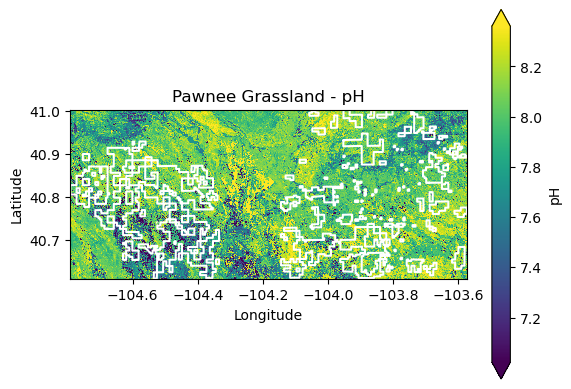

In [6]:
# Plot Pawnee to make sure it works/ looks right
polaris_pawnee_processed.plot(
    cbar_kwargs={"label": "pH"},
    robust=True,
    )

pawnee_grassland_gdf.to_crs(polaris_pawnee_processed.rio.crs).boundary.plot(
    ax=plt.gca(),
    color='white').set(
        title='Pawnee Grassland - pH',
        xlabel='Longitude', 
        ylabel='Latitude',
    )
plt.show()

## Pawnee Grassland - pH - plotted correctly - left area of grassland 
## appears to have slightly lower pH areas 

While the left area has slightly lower pH on the scale, pH of 7 and 8 is still 
considered netural to alkaline soil overall and is within the range that would 
be acceptable to a rocky mountain juniper. There is a full degree of longitude 
difference between the left and right areas of this grassland, so it makes sense 
that there is some variability in this range without adding additional context or 
other data it is hard to draw further conclusions so other raster sets will be 
downloaded next to eventually build a habitat suitability model.

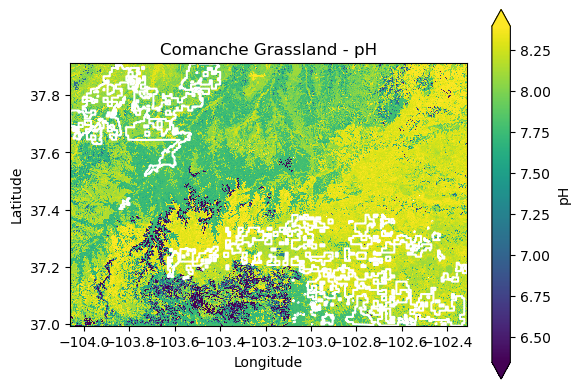

In [7]:
# Plot Pawnee to make sure it works/ looks right
polaris_comanche_processed.plot(
    cbar_kwargs={"label": "pH"},
    robust=True,
    )

comanche_grassland_gdf.to_crs(polaris_comanche_processed.rio.crs).boundary.plot(
    ax=plt.gca(),
    color='white').set(
        title='Comanche Grassland - pH',
        xlabel='Longitude', 
        ylabel='Latitude',
    )
plt.show()

## Comanche Grassland - pH - plotted correctly - the slightly acidic soil 
## areas appear to be outside the grassland visually. Full pH scale plotted 
## would work for the Rocky Mountain Juniper

The lower unit, Carrizo, is mostly in the upper range of the pH scale bar, 
while the upper unit, Timpas, if in the middle range of the scale bar. This 
range of pH plotted, is fully within the acceptable range for a Rocky Mountain 
Juniper. There is a larger range of pH here than with Pawnee. Without adding 
additional context or other data it is hard to draw further conclusions so 
other raster sets will be downloaded next to eventually build a habitat 
suitability model.

In [8]:
# Store variables needed in future notebooks
%store chosen_grasslands_bounds_gdfs polaris_processed_da_list 
%store polaris_comanche_processed polaris_pawnee_processed 

Stored 'chosen_grasslands_bounds_gdfs' (list)
Stored 'polaris_processed_da_list' (list)
Stored 'polaris_comanche_processed' (DataArray)
Stored 'polaris_pawnee_processed' (DataArray)
